In [1]:
import sys
import os
sys.path.append(os.path.abspath('..'))

import data_gen as dg

import torch
import geomloss

import matplotlib.pyplot as plt

# general situation for gaussian inference

In [2]:
def generate_gaussian_params(d, sigma_mu=0.1, sigma_cov=0.1, seed=0):
    torch.manual_seed(seed)
    
    mu = sigma_mu * torch.randn(d)

    A = sigma_cov * torch.randn(d, d)
    cov = A @ A.T + 1e-2 * torch.eye(d)

    return mu, cov

def generate_gaussian_data(mu, cov, n_samples, seed=0):
    torch.manual_seed(seed)

    L = torch.linalg.cholesky(cov)
    d = mu.shape[0]

    z = torch.randn(n_samples, d)
    samples = mu + z @ L.T

    return samples

In [3]:
def potential_grad(samples, mu, cov):

    diff = samples - mu
    precision = torch.linalg.inv(cov)

    grad = torch.linalg.solve(cov, diff.T).T
    return grad

In [4]:
def evolve_langevin(samples, mu, cov, eps=1e-2, n_evolution=1, seed=0):

    torch.manual_seed(seed)
    evolved_samples = samples.clone()

    for i in range(n_evolution):
        grad = potential_grad(evolved_samples, mu, cov)
        noise = torch.randn_like(evolved_samples)
        evolved_samples = evolved_samples - eps * grad + torch.sqrt(torch.tensor(2 * eps)) * noise

    return evolved_samples

In [5]:
sinkhorn_loss = geomloss.SamplesLoss(loss="sinkhorn", p=2, blur=0.05)

def lm_loss(samples, mu, cov):

    evolved_samples = evolve_langevin(samples, mu, cov)

    return sinkhorn_loss(samples, evolved_samples)

In [6]:
def plot_distributions(samples, evolved, epoch):
    d = samples.shape[1]

    plt.figure(figsize=(6, 5))

    if d == 1:
        samples_np = samples.cpu().numpy().flatten()
        evolved_np = evolved.cpu().numpy().flatten()
        plt.hist(samples_np, bins=50, alpha=0.5, label='Original', density=True)
        plt.hist(evolved_np, bins=50, alpha=0.5, label='Evolved', density=True)
        plt.xlabel("x")

    elif d == 2:
        samples_np = samples.cpu().numpy()
        evolved_np = evolved.cpu().numpy()
        plt.scatter(samples_np[:, 0], samples_np[:, 1], alpha=0.3, label='Original', s=10)
        plt.scatter(evolved_np[:, 0], evolved_np[:, 1], alpha=0.3, label='Evolved', s=10)
        plt.xlabel("x1")
        plt.ylabel("x2")

    else:
        print(f"plot not implemented for dimension d = {d}")
        return

    plt.legend()
    plt.title(f"epoch {epoch}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [7]:
def lm_optimize(samples, n_epochs=1000, lr=1e-2, seed=10, eps=1e-2, n_evolution=10, plot_every=500):

    d = samples.shape[1]
    torch.manual_seed(seed)

    mu = torch.randn(d, requires_grad=True)
    a = torch.randn(d, d, requires_grad=True)

    optimizer = torch.optim.Adam([mu, a], lr=lr)

    for epoch in range(n_epochs):
        optimizer.zero_grad()
        cov = a.T @ a
        loss = lm_loss(samples, mu, cov)
        loss.backward()
        optimizer.step()

        if epoch % plot_every == 0 or epoch == n_epochs - 1:
            print(f"epoch {epoch} | loss = {loss.item():.6f} | mean = {mu} | cov = {cov}")
            with torch.no_grad():
                evolved_samples = evolve_langevin(samples, mu, cov)
                plot_distributions(samples, evolved_samples, epoch)

    return mu.detach(), cov.detach()

tensor([15.4100, -2.9343]) 

 tensor([[20.2909,  6.2718],
        [ 6.2718, 12.5390]]) 




epoch 0 | loss = 0.034211 | mean = tensor([-0.5914, -1.0222], requires_grad=True) | cov = tensor([[0.9375, 0.0506],
        [0.0506, 1.6286]], grad_fn=<MmBackward0>)


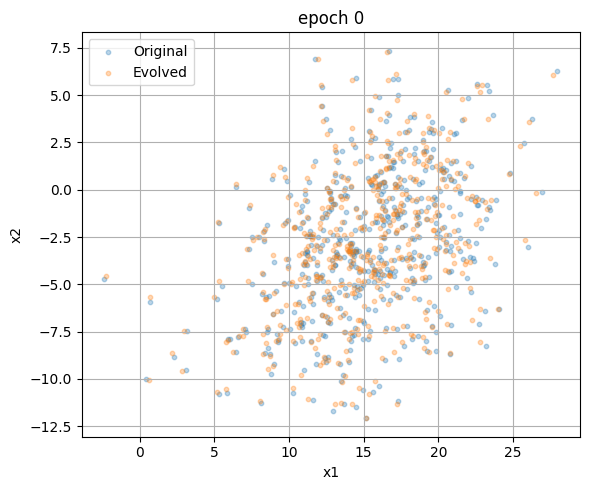

epoch 500 | loss = 0.018169 | mean = tensor([ 0.7767, -3.3973], requires_grad=True) | cov = tensor([[ 6.4676, -0.2453],
        [-0.2453,  4.1228]], grad_fn=<MmBackward0>)


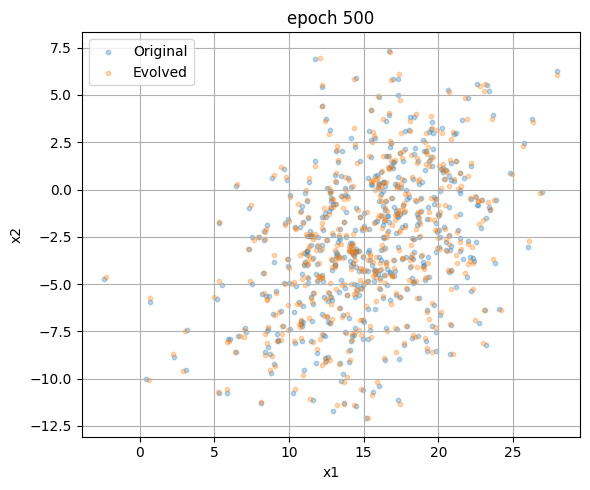

epoch 1000 | loss = 0.017974 | mean = tensor([ 1.3590, -5.0865], requires_grad=True) | cov = tensor([[ 9.6873, -0.2321],
        [-0.2321,  5.1373]], grad_fn=<MmBackward0>)


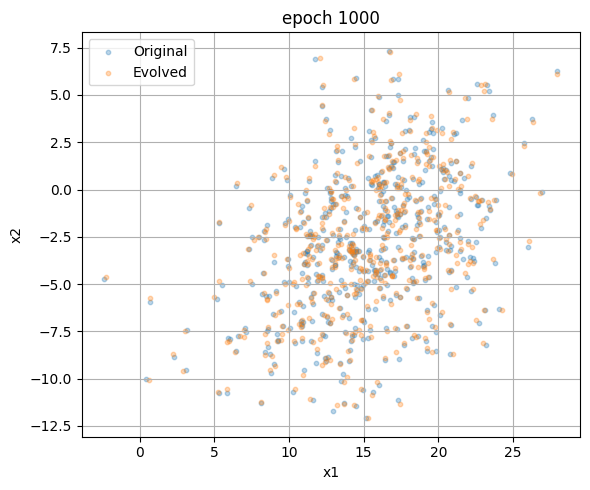

epoch 1500 | loss = 0.017911 | mean = tensor([ 1.8228, -6.6839], requires_grad=True) | cov = tensor([[12.4842,  0.0781],
        [ 0.0781,  5.7626]], grad_fn=<MmBackward0>)


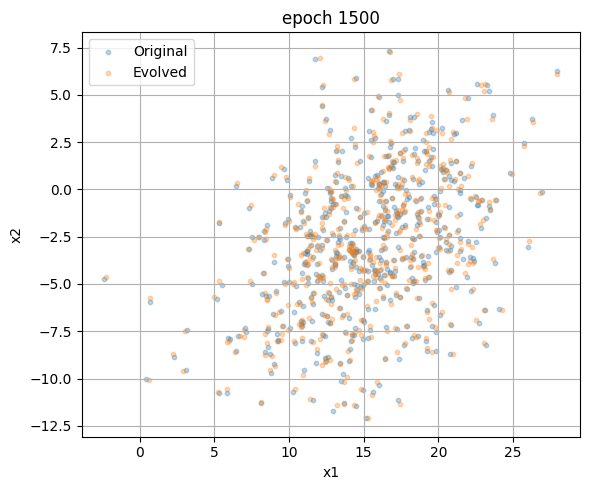

epoch 2000 | loss = 0.017880 | mean = tensor([ 2.2391, -8.2497], requires_grad=True) | cov = tensor([[15.0949,  0.7111],
        [ 0.7111,  6.2565]], grad_fn=<MmBackward0>)


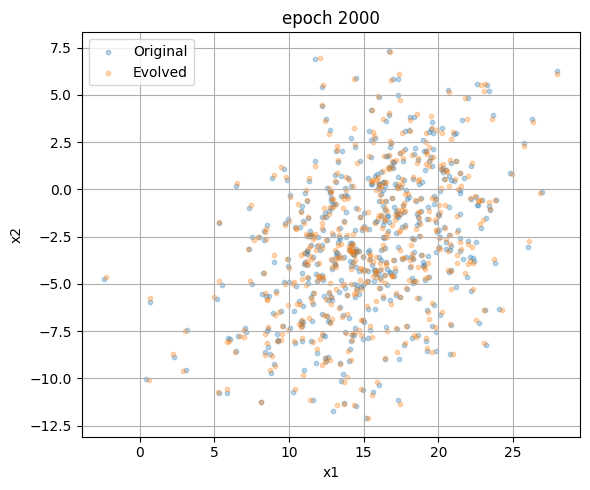

epoch 2500 | loss = 0.017862 | mean = tensor([ 2.6321, -9.7729], requires_grad=True) | cov = tensor([[17.6016,  1.6342],
        [ 1.6342,  6.8067]], grad_fn=<MmBackward0>)


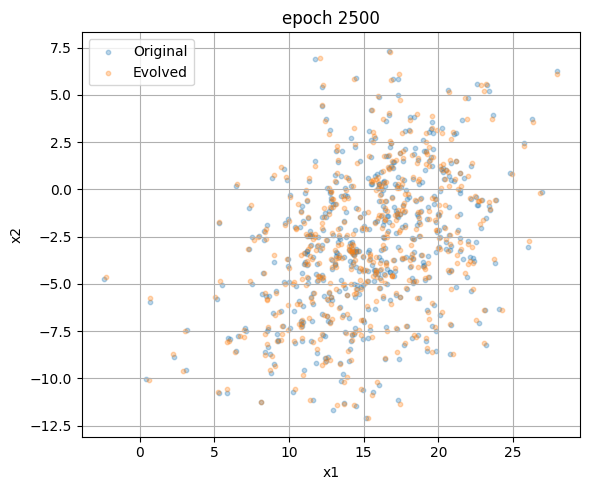

epoch 3000 | loss = 0.017853 | mean = tensor([  3.0103, -11.2163], requires_grad=True) | cov = tensor([[20.0454,  2.7307],
        [ 2.7307,  7.5372]], grad_fn=<MmBackward0>)


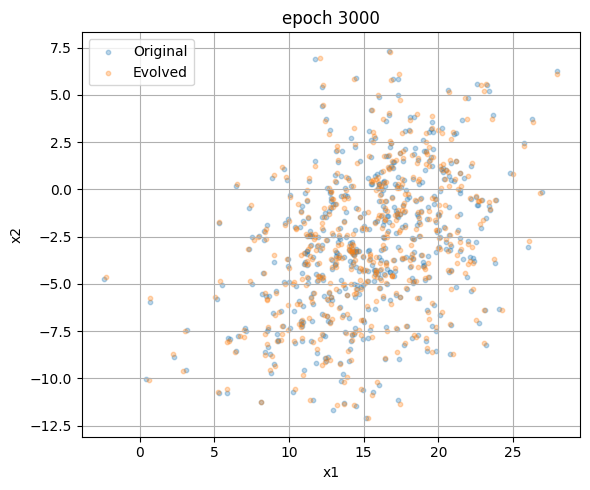

epoch 3500 | loss = 0.017844 | mean = tensor([  3.3758, -12.5469], requires_grad=True) | cov = tensor([[22.4677,  3.8424],
        [ 3.8424,  8.4667]], grad_fn=<MmBackward0>)


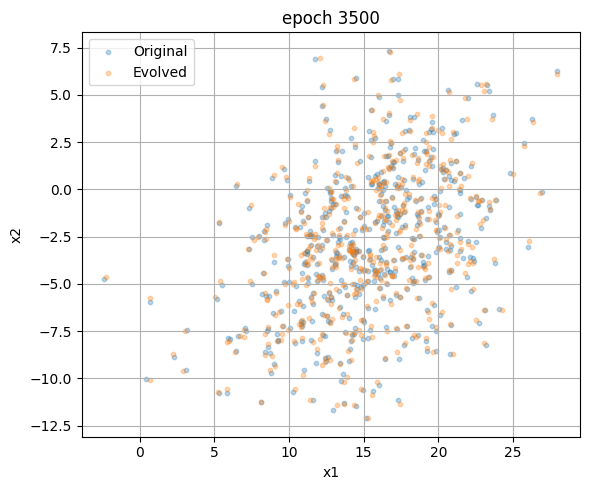

epoch 4000 | loss = 0.017839 | mean = tensor([  3.7303, -13.7562], requires_grad=True) | cov = tensor([[24.9221,  4.8415],
        [ 4.8415,  9.5200]], grad_fn=<MmBackward0>)


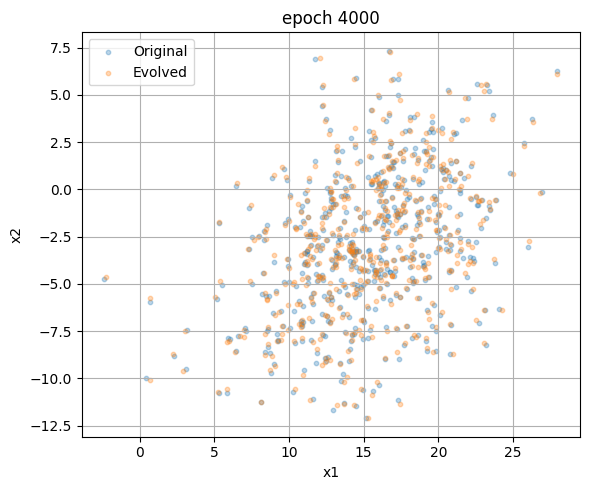

epoch 4500 | loss = 0.017835 | mean = tensor([  4.0771, -14.8588], requires_grad=True) | cov = tensor([[27.4698,  5.6930],
        [ 5.6930, 10.6222]], grad_fn=<MmBackward0>)


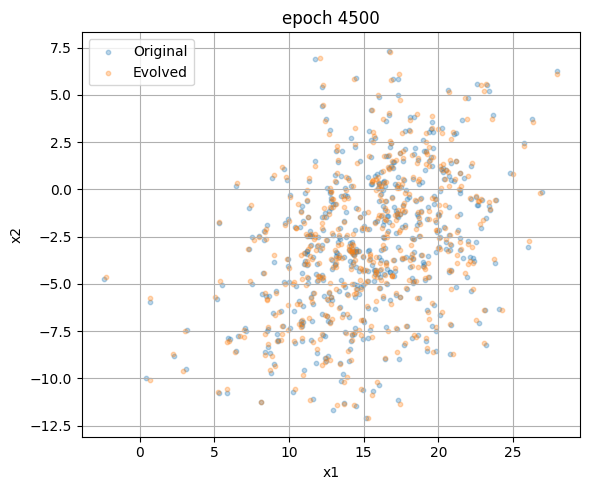

epoch 5000 | loss = 0.017832 | mean = tensor([  4.4205, -15.8789], requires_grad=True) | cov = tensor([[30.1709,  6.4000],
        [ 6.4000, 11.7168]], grad_fn=<MmBackward0>)


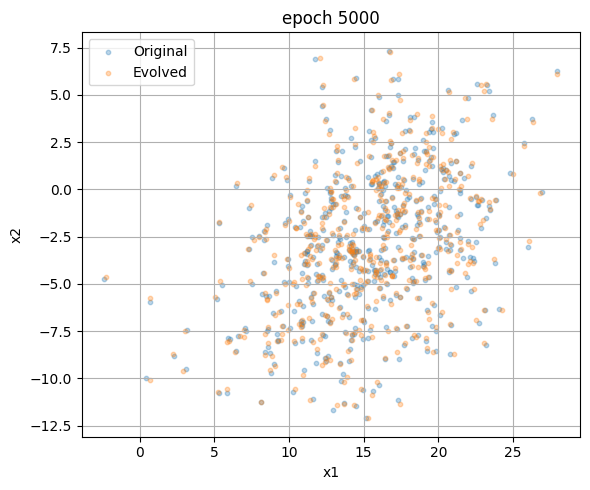

epoch 5500 | loss = 0.017829 | mean = tensor([  4.7654, -16.8418], requires_grad=True) | cov = tensor([[33.0843,  7.0137],
        [ 7.0137, 12.7943]], grad_fn=<MmBackward0>)


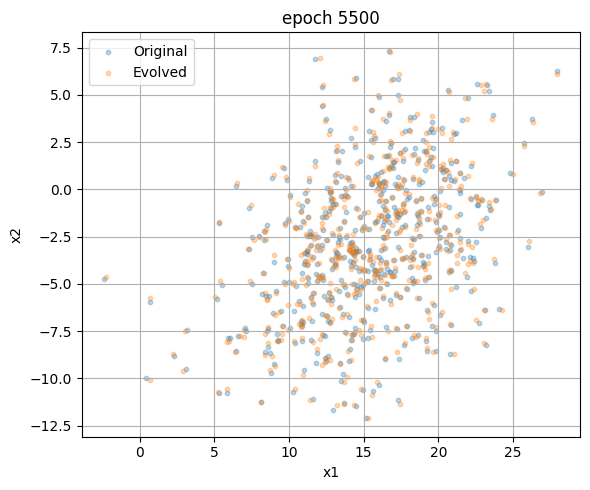

epoch 6000 | loss = 0.017828 | mean = tensor([  5.1155, -17.7669], requires_grad=True) | cov = tensor([[36.2639,  7.5571],
        [ 7.5571, 13.8471]], grad_fn=<MmBackward0>)


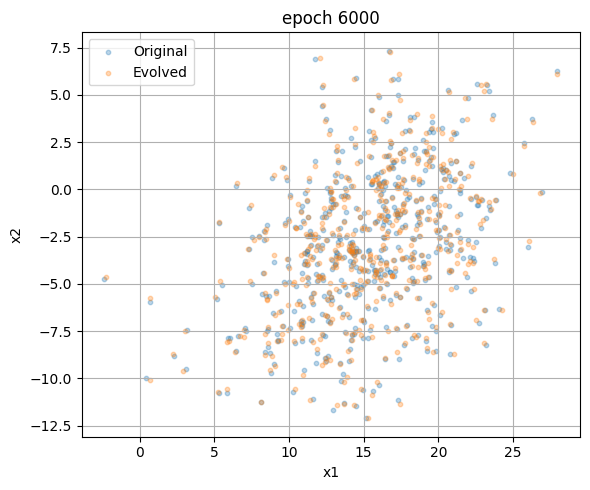

epoch 6500 | loss = 0.017826 | mean = tensor([  5.4746, -18.6702], requires_grad=True) | cov = tensor([[39.7661,  8.0563],
        [ 8.0563, 14.8723]], grad_fn=<MmBackward0>)


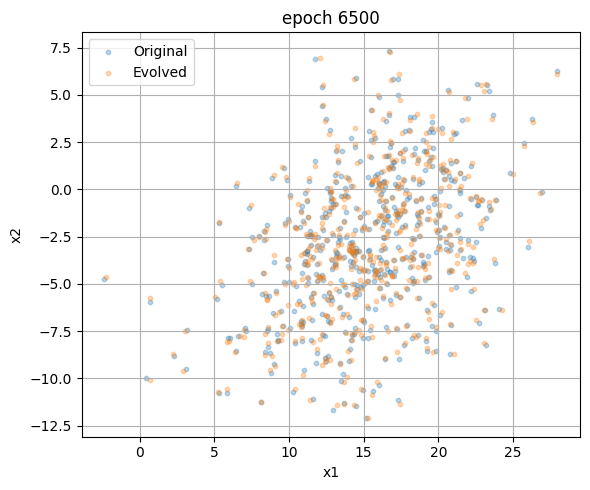

epoch 7000 | loss = 0.017825 | mean = tensor([  5.8458, -19.5627], requires_grad=True) | cov = tensor([[43.6480,  8.5486],
        [ 8.5486, 15.8909]], grad_fn=<MmBackward0>)


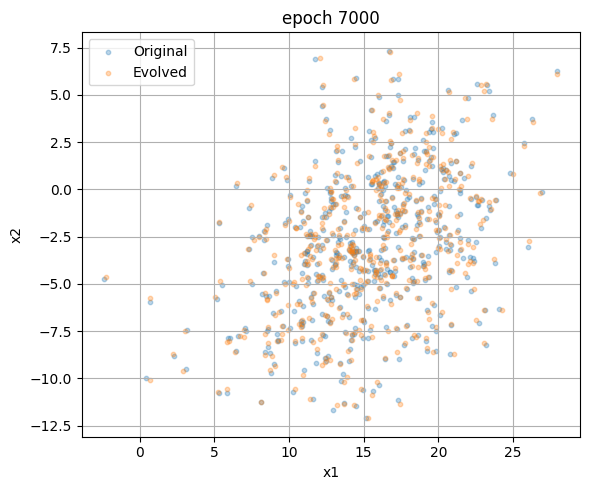

epoch 7500 | loss = 0.017825 | mean = tensor([  6.2317, -20.4519], requires_grad=True) | cov = tensor([[47.9709,  9.0340],
        [ 9.0340, 16.8969]], grad_fn=<MmBackward0>)


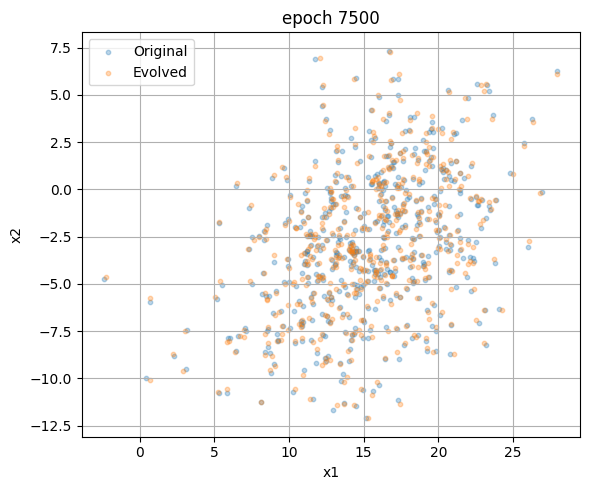

epoch 8000 | loss = 0.017823 | mean = tensor([  6.6346, -21.3421], requires_grad=True) | cov = tensor([[52.7998,  9.5230],
        [ 9.5230, 17.9041]], grad_fn=<MmBackward0>)


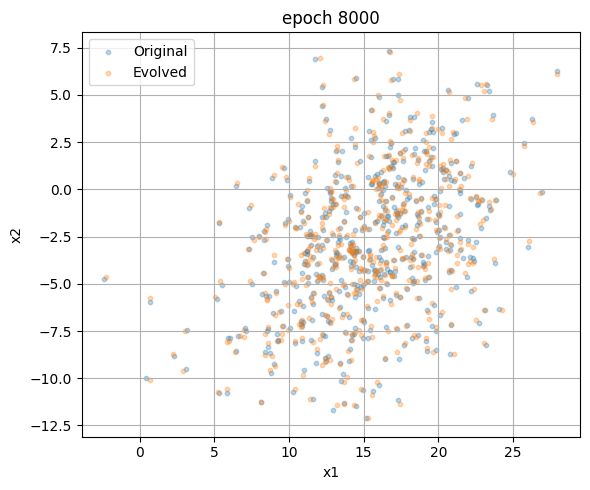

epoch 8500 | loss = 0.017823 | mean = tensor([  7.0578, -22.2409], requires_grad=True) | cov = tensor([[58.2108, 10.0393],
        [10.0393, 18.9005]], grad_fn=<MmBackward0>)


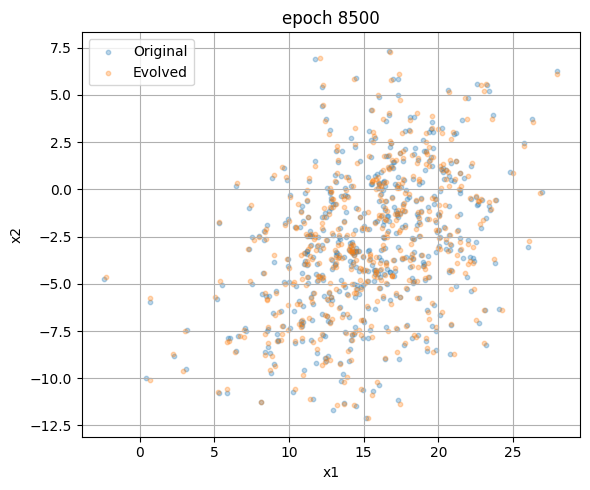

epoch 9000 | loss = 0.017821 | mean = tensor([  7.5035, -23.1475], requires_grad=True) | cov = tensor([[64.2836, 10.5971],
        [10.5971, 19.9081]], grad_fn=<MmBackward0>)


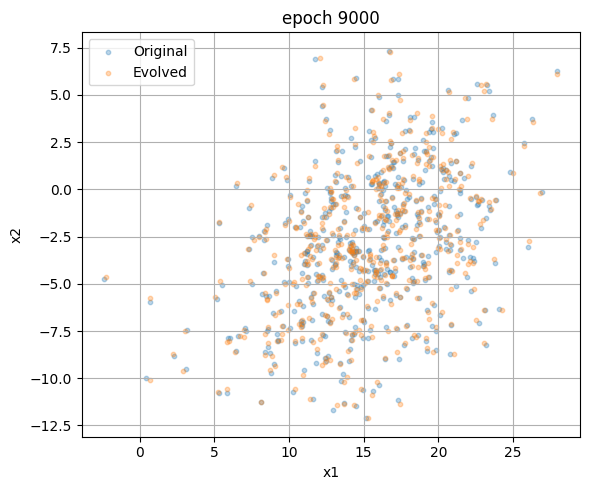

epoch 9500 | loss = 0.017821 | mean = tensor([  7.9747, -24.0628], requires_grad=True) | cov = tensor([[71.1082, 11.2063],
        [11.2063, 20.9233]], grad_fn=<MmBackward0>)


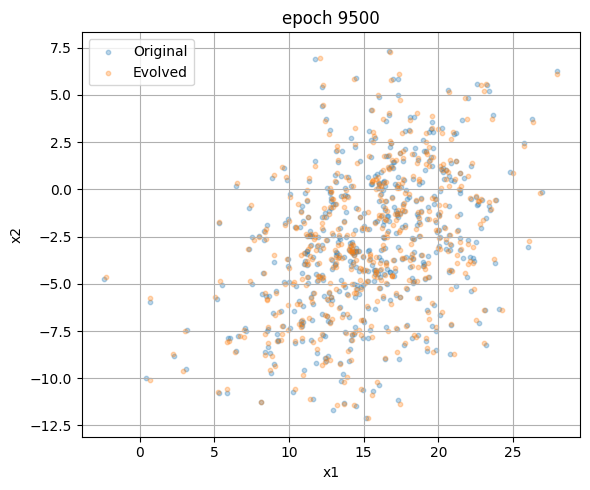

epoch 10000 | loss = 0.017821 | mean = tensor([  8.4746, -24.9868], requires_grad=True) | cov = tensor([[78.7846, 11.8891],
        [11.8891, 21.9519]], grad_fn=<MmBackward0>)


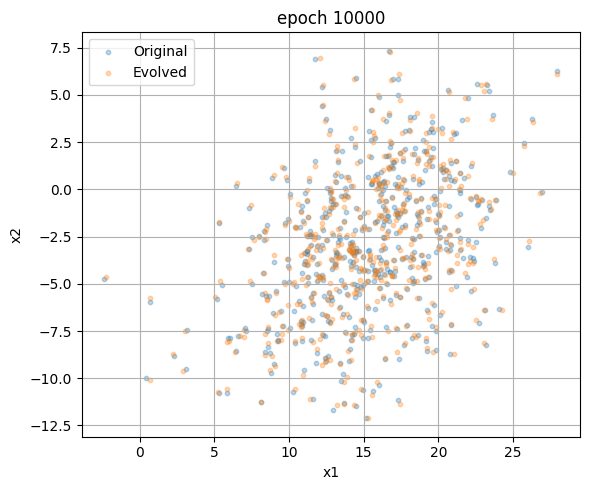

epoch 10500 | loss = 0.017820 | mean = tensor([  9.0064, -25.9177], requires_grad=True) | cov = tensor([[87.4228, 12.6337],
        [12.6337, 22.9735]], grad_fn=<MmBackward0>)


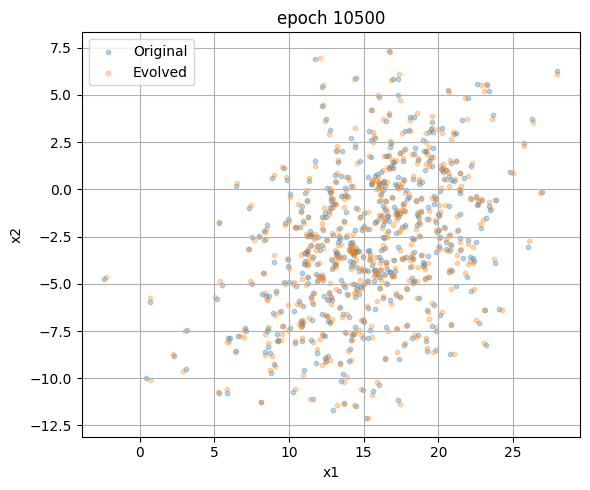

epoch 11000 | loss = 0.017819 | mean = tensor([  9.5739, -26.8511], requires_grad=True) | cov = tensor([[97.1453, 13.4925],
        [13.4925, 24.0149]], grad_fn=<MmBackward0>)


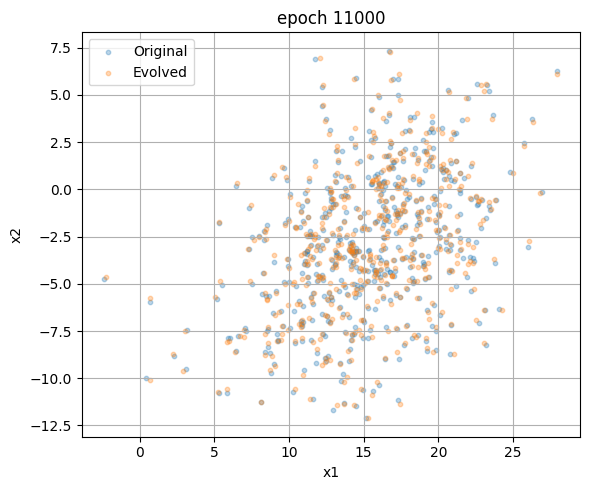

epoch 11500 | loss = 0.017820 | mean = tensor([ 10.1805, -27.7798], requires_grad=True) | cov = tensor([[108.0846,  14.4298],
        [ 14.4298,  25.0676]], grad_fn=<MmBackward0>)


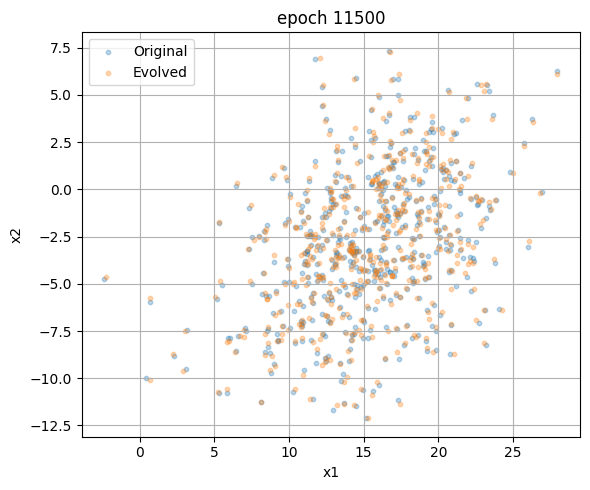

epoch 12000 | loss = 0.017820 | mean = tensor([ 10.8314, -28.7033], requires_grad=True) | cov = tensor([[120.3929,  15.5065],
        [ 15.5065,  26.1080]], grad_fn=<MmBackward0>)


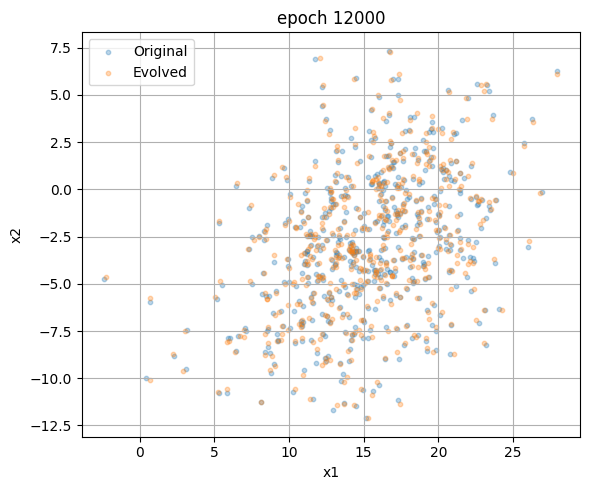

epoch 12500 | loss = 0.017820 | mean = tensor([ 11.5305, -29.6065], requires_grad=True) | cov = tensor([[134.2291,  16.7249],
        [ 16.7249,  27.1729]], grad_fn=<MmBackward0>)


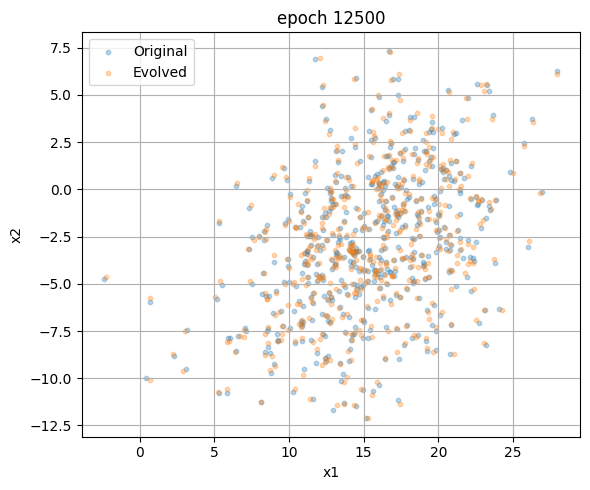

epoch 13000 | loss = 0.017818 | mean = tensor([ 12.2834, -30.4840], requires_grad=True) | cov = tensor([[149.7741,  18.0968],
        [ 18.0968,  28.1973]], grad_fn=<MmBackward0>)


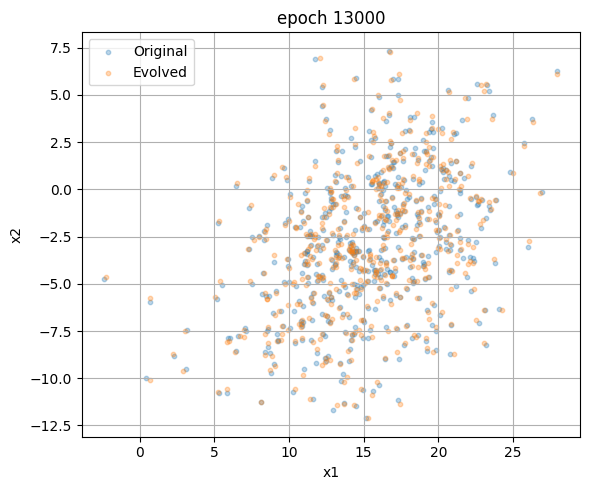

epoch 13500 | loss = 0.017819 | mean = tensor([ 13.0954, -31.3199], requires_grad=True) | cov = tensor([[167.2194,  19.6550],
        [ 19.6550,  29.2131]], grad_fn=<MmBackward0>)


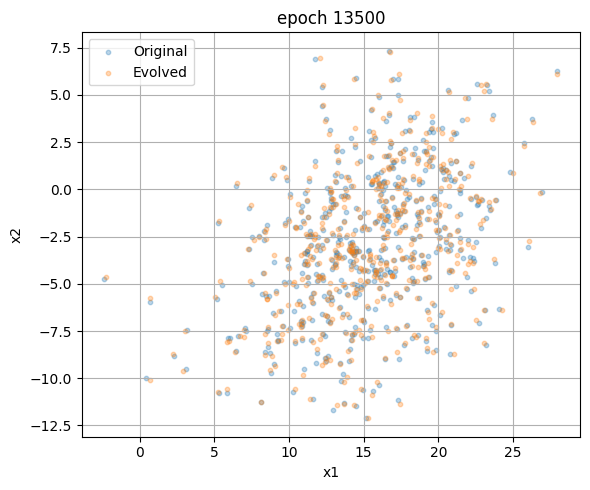

epoch 14000 | loss = 0.017818 | mean = tensor([ 13.9716, -32.1057], requires_grad=True) | cov = tensor([[186.7735,  21.3737],
        [ 21.3737,  30.2023]], grad_fn=<MmBackward0>)


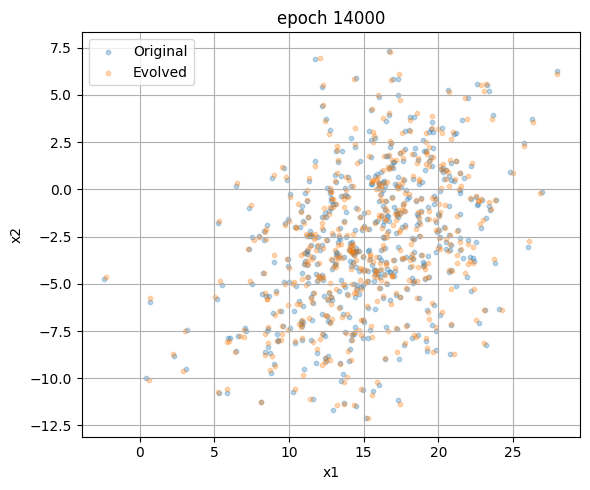

epoch 14500 | loss = 0.017818 | mean = tensor([ 14.9187, -32.8276], requires_grad=True) | cov = tensor([[208.6642,  23.4412],
        [ 23.4412,  31.1776]], grad_fn=<MmBackward0>)


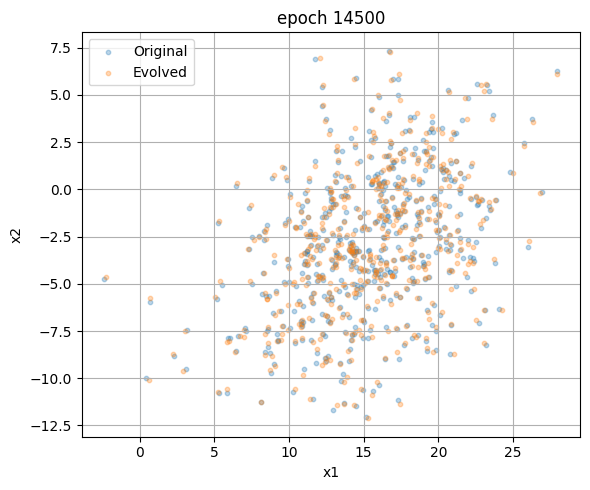

epoch 14999 | loss = 0.017818 | mean = tensor([ 15.9394, -33.4603], requires_grad=True) | cov = tensor([[233.0745,  25.6071],
        [ 25.6071,  32.0640]], grad_fn=<MmBackward0>)


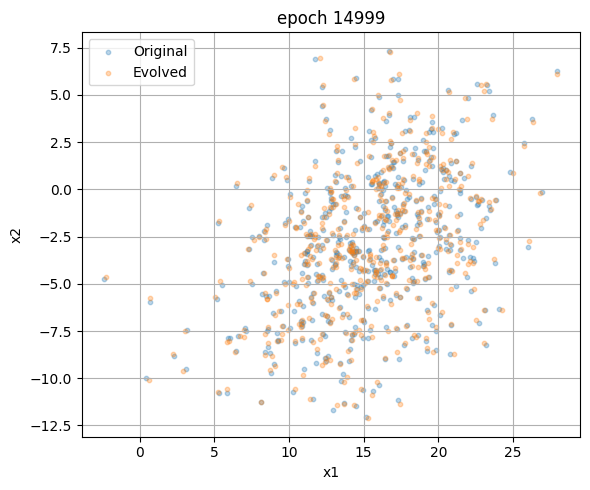


--------- results: ---------
mu true:      tensor([15.4100, -2.9343])
mu hat:   tensor([ 15.9394, -33.4603])
cov true:
 tensor([[20.2909,  6.2718],
        [ 6.2718, 12.5390]])
cov hat:
 tensor([[233.0745,  25.6071],
        [ 25.6071,  32.0640]])


In [8]:
d = 2
mu_true, cov_true = generate_gaussian_params(d, sigma_mu=10, sigma_cov=2, seed=0)
samples = generate_gaussian_data(mu_true, cov_true, n_samples=500, seed=1)
print(mu_true, "\n\n", cov_true, "\n\n\n\n")

mu_hat, cov_hat = lm_optimize(samples, n_epochs=15000, lr=1e-2)

print("\n--------- results: ---------")
print("mu true:     ", mu_true)
print("mu hat:  ", mu_hat)
print("cov true:\n", cov_true)
print("cov hat:\n", cov_hat)